Step 17 (Speical Topic 1): Implicit Solver
----
***

In this step, we will tackle the 2D Poisson's equation utilizing two distinct methods: an explicit solver, which remains the same as the one outlined in Step 12, followed by the introduction of Newton's method. Utilizing JAX, we will then implement an implicit solver to effectively address the equation in a different approach.


### Explicit solver

Poisson's equation is obtained from adding a source term to the right-hand-side of Laplace's equation:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

So, unlinke the Laplace equation, there is some finite value inside the field that affects the solution. Poisson's equation acts to "relax" the initial sources in the field.

In discretized form, this looks almost the same as Step 12:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

As before, we rearrange this so that we obtain an equation for $p$ at point $i,j$. Thus, we obtain:

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

We will solve this equation by assuming an initial state of $p=0$ everywhere, and applying boundary conditions as follows:

$p=0$ at $x=0, \ 2$ and $y=0, \ 2$

and the source term consists of two initial spikes inside the domain, as follows:

$b=100$ at $(x,y) = (0.5,0.5)$

$b=-100$ at $(x,y) = (1.5,1.5)$

$b_{i,j}=0$ everywhere else.



In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# parameter definitions

nx = 50
ny = 50
nt = 100
xmin = 0
xmax = 2
ymin = 0
ymax = 2

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

p = np.zeros((nx, ny))
b = np.zeros((nx, ny))
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)

# define source term
b[int(nx/4),int(nx/4)] = 100
b[int(3*ny/4),int(3*ny/4)] = -100


In [3]:
def plot2D(x,y,p):  # define a function for visulizing 2d plot
    fig = plt.figure(figsize = (11,7), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    # The '111' means a grid of 1 row and 1 column and this subplot is the first one.
    X, Y = np.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p,cmap=cm.viridis)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$');

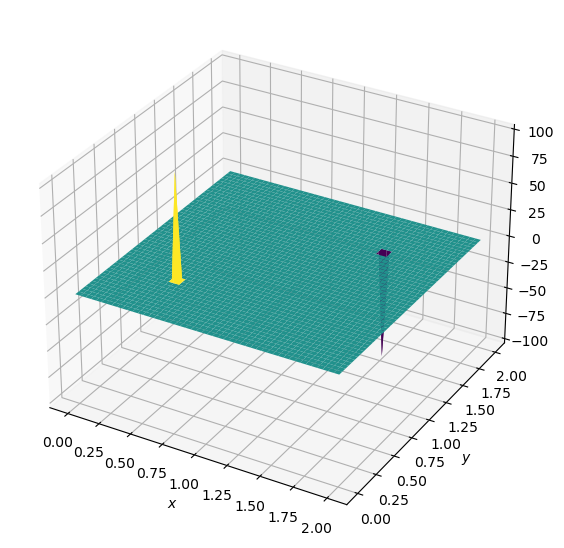

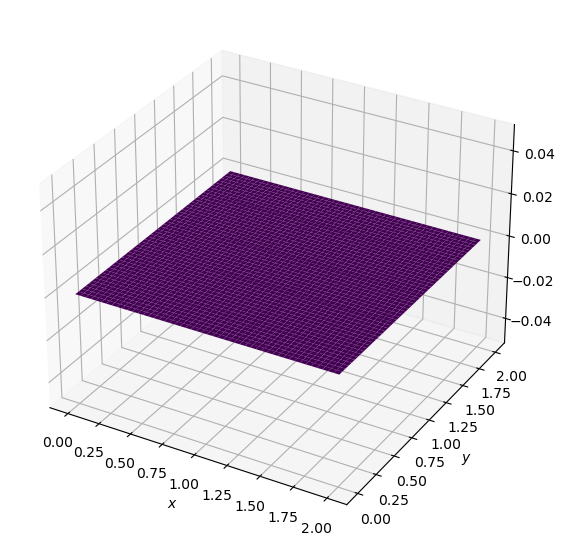

In [4]:
plot2D(x,y,b)
plot2D(x,y,p)

In [5]:
def poisson2d(p, b, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.zeros_like(p)
    small = 1e-8
    niter = 0
    while l1norm > l1norm_target:
        niter += 1   # count the number of iterations for convergence
        pn = p.copy()
        p[1:-1,1:-1] = ((dy**2 * (pn[2:,1:-1] + pn[:-2,1:-1]) +
                        dx**2 * (pn[1:-1,2:] + pn[1:-1,:-2]) -
                        dx**2 * dy**2 * b[1:-1,1:-1]) /
                        (2 * (dx**2 + dy**2)))
        p[0,:] = 0  # p = 0 @ x = 0
        p[-1:,] = 0 # p = 0 @ x = 2
        p[:,0] = 0 # p = 0 @ y = 0
        p[:,-1] = 0 # p = 0 @ y = 2  
        l1norm = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
        
    return p, niter

Output of this function is a tuple (Python Tuple is a collection of objects separated by commas)

In [6]:
p, niter = poisson2d(p, b, dx, dy, 1e-4)  
print('# of iterations =', niter)

# of iterations = 791


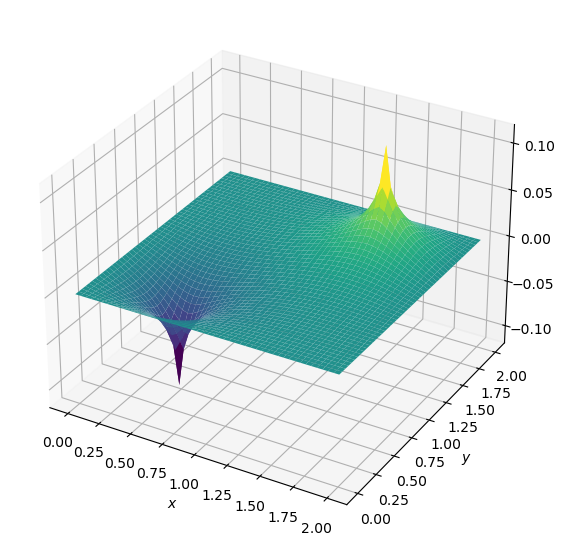

In [7]:
plot2D(x,y,p)

Next, we will use implicit method to solve the same Possion equation:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

### Explicit vs. Implicit Methods for the 2D Poisson Equation

The 2D Poisson equation is a partial differential equation that describes phenomena such as heat conduction, electrostatics, and fluid flow. It's given by:

$$ \nabla^2 \phi = f $$

Where $ \nabla^2 $ is the Laplacian operator and $ f $ is a source term.

#### Explicit Method

In the explicit method, the new value of the function (e.g., temperature or potential) at a grid point is computed using values from the current time level.

##### Finite Difference Discretization:

$$ \frac{\phi_{i+1, j} - 2\phi_{i,j} + \phi_{i-1, j}}{\Delta x^2} + \frac{\phi_{i, j+1} - 2\phi_{i,j} + \phi_{i, j-1}}{\Delta y^2} = f_{i,j} $$

##### Update Rule:

$$ \phi^{new}_{i,j} = \phi^{old}_{i,j} + \Delta t \left( \frac{\phi^{old}_{i+1, j} - 2\phi^{old}_{i,j} + \phi^{old}_{i-1, j}}{\Delta x^2} + \frac{\phi^{old}_{i, j+1} - 2\phi^{old}_{i,j} + \phi^{old}_{i, j-1}}{\Delta y^2} - f_{i,j} \right) $$

##### Characteristics:
- **Stability constraints**: Explicit methods often have a stability constraint on the time step, i.e., conditionally stable.
- **Easy to implement**: No need to solve a system of equations.
  
#### Implicit Method

In the implicit method, the new value at a grid point is computed using values from both the current and the new time levels. This often requires solving a system of linear equations at each time step.

##### Finite Difference Discretization:

$$ \frac{\phi^{new}_{i+1, j} - 2\phi^{new}_{i,j} + \phi^{new}_{i-1, j}}{\Delta x^2} + \frac{\phi^{new}_{i, j+1} - 2\phi^{new}_{i,j} + \phi^{new}_{i, j-1}}{\Delta y^2} = f_{i,j} $$

##### Update Rule:

To find $ \phi^{new}_{i,j} $, solve the system of linear equations formed by discretizing the whole domain.

##### Characteristics:
- **Unconditionally stable**: Often no explicit stability constraint on the time step.
- **Computationally more intensive**: Need to solve a system of equations at each time step, typically requiring matrix inversion or iterative solvers.

#### Conclusion

- **Explicit methods** are straightforward to implement and are computationally less expensive per time step. However, they might require very small time steps to be stable.
- **Implicit methods** can handle larger time steps and are unconditionally stable for many problems, but they are more computationally intensive per time step.

The choice between explicit and implicit often depends on the specific problem, computational resources, and desired accuracy.



In [8]:
import jax
import jax.numpy as jnp
import numpy as np


In [9]:
def get_A_fn_linear_fn(dofs, fn):
    """
    Generate the Jacobian-vector-product function based on the residual function.
    
    Args:
    - dofs (array-like): The degrees of freedom or the state vector.
    - fn (function): The residual function.
    
    Returns:
    - function: A function representing the action of the Jacobian on a vector.
    """
    def A_fn_linear_fn(inc):
        primals, tangents = jax.jvp(fn, (dofs,), (inc,))
        return tangents
    return A_fn_linear_fn


def solver_linear(A_fn,dofs,tol=1e-6):
    """
    Solve the linear system using the BiCGSTAB method.
    
    Args:
    - A_fn (function): The residual function.
    - dofs (array-like): Initial guess for the solution (flatten).
    - tol (float): Tolerance for the solver.
    
    Returns:
    - array-like: Updated degrees of freedom or state vector.
    - float: Norm of the residual.
    """
    b = -A_fn(dofs)
    A_fn_linear = get_A_fn_linear_fn(dofs, A_fn)
    inc, info = jax.scipy.sparse.linalg.bicgstab(A_fn_linear, b, tol=tol)
    dofs = dofs + inc
    
    res_norm = np.linalg.norm(A_fn(dofs))/np.linalg.norm(b)
    return dofs,res_norm

# 2D laplace: central difference
def laplace(f,dX):
    """
    Compute the 2D Laplacian using central difference scheme.
    
    Args:
    - f (2D array-like): Function values on a 2D grid.
    - dX (array-like): Grid spacings in x and y directions.
    
    Returns:
    - 2D array-like: Laplacian of f.
    """
    dif = jnp.zeros_like(f)
    
    dif = dif.at[1:-1, 1:-1].set((1 / dX[0]**2 *
                        (f[2:,1:-1] - 2 * f[1:-1, 1:-1] + f[0:-2,1:-1]) +
                        1 / dX[1]**2 *
                        (f[1:-1,2:] - 2 * f[1:-1, 1:-1] + f[1:-1,0:-2])))
    return dif

def compute_residual(p,b,dX):
    """
    Compute the residual for the Laplace equation.
    
    Args:
    - p (2D array-like): Function values on a 2D grid.
    - b (2D array-like): Source term.
    - dX (array-like): Grid spacings in x and y directions.
    
    Returns:
    - array-like: Flattened residual values.
    """
    res = laplace(p,dX) - b
            
    return res.flatten()

def A_fn(p):
    """
    Compute the residual function for a given state vector.
    
    Args:
    - p (array-like): Flattened state vector.
    
    Returns:
    - array-like: Residual values for the state vector p (flattened).
    """
    p = p.reshape((Nx,Ny))
    return compute_residual(p,b,dX)


### Newton's Method: 1D vs. High-Dimensional

Newton's method is an iterative technique used to find approximate solutions to the equation $ f(x) = 0 $. The iteration process uses an initial guess $ x_0 $ and refines the guess using the formula:

$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$

#### 1D Newton's Method

In one dimension, the formula is simple and involves the function value $ f(x) $ and its derivative $ f'(x) $.

Visualize a curve on the coordinate plane. The idea of Newton's method is to approximate the curve by a tangent line and then to use the x-intercept of this tangent line as the next approximation.

#### High-Dimensional Newton's Method

For functions $ f: \mathbb{R}^n \rightarrow \mathbb{R}^m $, the Newton's method generalizes by using the Jacobian matrix to solve $f(\mathbf{x})=0$.

##### The Jacobian Matrix

The Jacobian matrix $ J $ of a function $ f: \mathbb{R}^n \rightarrow \mathbb{R}^m $ is an $ m \times n $ matrix, where each entry is given by:

$$ J_{ij} = \frac{\partial f_i}{\partial x_j} $$

So, the Jacobian is essentially a matrix that consists of all the first-order partial derivatives of a vector-valued function.

In the context of Newton's method for systems of equations, the Jacobian matrix plays a role analogous to the derivative in the 1D case.

For a system of equations, the Newton's method iteration formula becomes:

$$ \mathbf{x}_{n+1} = \mathbf{x}_n - J^{-1}(\mathbf{x}_n) \mathbf{f}(\mathbf{x}_n) $$

Where:
- $ \mathbf{x}_n $ is the current approximation (a vector in $ \mathbb{R}^n $).
- $ J^{-1}(\mathbf{x}_n) $ is the inverse of the Jacobian matrix evaluated at $ \mathbf{x}_n $.
- $ \mathbf{f}(\mathbf{x}_n) $ is the function value (a vector in $ \mathbb{R}^n $) at the current approximation.

Then, we can convert the Newton's method to a linear system, where $f$ is the residual function of our soltuion $\mathbf{p}$. The residual function is zero when the input $\mathbf{p}$ is exact:

$$ J(\mathbf{x}_n)\Delta \mathbf{x} = - \mathbf{f}(\mathbf{x}_n) $$

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


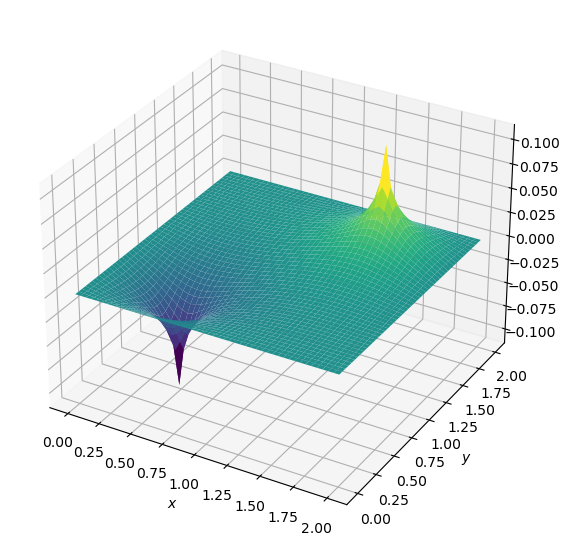

In [10]:
# parameter definitions

Nx = 50
Ny = 50
xmin = 0
xmax = 2
ymin = 0
ymax = 2

cell_num = Nx*Ny
num_nodes = (Nx + 1) * (Ny + 1)

dx = (xmax - xmin) / (Nx - 1)
dy = (ymax - ymin) / (Ny - 1)

x = np.linspace(xmin, xmax, Nx )
y = np.linspace(ymin, ymax, Ny )
xx, yy = np.meshgrid(x, y, indexing='ij')

#points = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
# xc = jnp.array((xx[1:, 1:] + xx[:-1, 1:])/2)[:, :,None]
# yc = jnp.array((yy[1:, 1:] + yy[1:, :-1])/2)[:, :,None]

dX = jnp.array([(xmax - xmin)/Nx, (ymax - ymin)/Ny])

p = jnp.zeros((Nx, Ny))
b = jnp.zeros((Nx, Ny))

# define source term
b = b.at[int(Nx/4), int(Ny/4)].set(100)
b = b.at[int(3*Nx/4), int(3*Ny/4)].set(-100)


dofs = jnp.zeros(Nx*Ny)  # initial guess of the solution (flatten)

dofs,res = solver_linear(A_fn,dofs)

p = dofs.reshape(Nx,Ny)

plot2D(x,y,p)